In [1]:
#!/usr/bin/env python
# build_gene_graph.py

import os
import pandas as pd
import torch
from torch_geometric.data import Data
from collections import Counter

# ----- Paths -----
FEATURE_TSV = "/home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv"
VALID_TSV = "/home/zihend1/Genesis/KNOT/data/symbol/valid_gene_symbols.tsv"
REGNET_SRC = "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Edge/GRN/RegNetwork/Human/human.source"
TRRUST_TSV = "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Edge/GRN/TRRUST/trrust_rawdata.human.tsv"
COEXP_TSV = "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Edge/GCN/GENEFRIENDS/homo_sapiens_sapiens/GTEx/coexpression_edges_90p.tsv"
PPI_TSV = "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Edge/PPI/STRING/ppi_symbol_links.tsv"
OUTPUT_PTG = "gene_graph.pt"
LABEL_TYPE = "druggability_tier"  # or "idgTDL"

# ----- Load valid genes -----
valid_genes = pd.read_csv(VALID_TSV, header=None, names=["Gene_Symbol"])["Gene_Symbol"].tolist()
print(f"✅ Loaded valid genes: {len(valid_genes)}")

# ----- Load features and labels -----
df = pd.read_csv(FEATURE_TSV, sep="\t")

# 筛选 valid genes，并去除重复 Gene_Symbol
df = df[df["Gene_Symbol"].isin(valid_genes)]
df = df.drop_duplicates(subset="Gene_Symbol")  # ✅ 去重
print(f"✅ Filtered features: {df.shape}")

# ----- Separate features and label -----
all_columns = df.columns.tolist()
feature_cols = [c for c in all_columns if c not in ["Gene_Symbol", "known_gene", "druggability_tier", "idgTDL"]]
label_series = df[LABEL_TYPE].fillna("-1")
print(f"✅ Using label: {LABEL_TYPE} (unique={label_series.nunique()})")

# ----- Build node index mapping -----
genes = df["Gene_Symbol"].tolist()
gene2idx = {gene: i for i, gene in enumerate(genes)}
x = torch.tensor(df[feature_cols].values, dtype=torch.float)
print(f"✅ Feature tensor shape: {x.shape}")

# ----- Load RegNetwork -----
reg_edges = []
with open(REGNET_SRC) as f:
    for line in f:
        src, _, tgt, _ = line.strip().split("\t")
        if src in gene2idx and tgt in gene2idx:
            reg_edges.append((gene2idx[src], gene2idx[tgt]))
print(f"📘 RegNetwork edges: {len(reg_edges):,}")

# ----- Load TRRUST -----
trrust = pd.read_csv(TRRUST_TSV, sep="\t", header=None, names=["TF", "Target", "Effect", "PubMed"])
trrust_edges = [(gene2idx[s], gene2idx[t]) for s, t in zip(trrust.TF, trrust.Target) if s in gene2idx and t in gene2idx]
print(f"📙 TRRUST edges: {len(trrust_edges):,}")

# ----- Load Coexpression -----
coexp = pd.read_csv(COEXP_TSV, sep="\t")
coexp_edges = [(gene2idx[g1], gene2idx[g2]) for g1, g2 in zip(coexp["Gene1"], coexp["Gene2"]) if g1 in gene2idx and g2 in gene2idx]
print(f"📗 Coexpression edges: {len(coexp_edges):,}")

# ----- Load PPI -----
ppi = pd.read_csv(PPI_TSV, sep="\t")
ppi_edges = [(gene2idx[g1], gene2idx[g2]) for g1, g2 in zip(ppi["gene1"], ppi["gene2"]) if g1 in gene2idx and g2 in gene2idx]
print(f"📕 PPI edges: {len(ppi_edges):,}")

# ----- Merge edges -----
all_edges = reg_edges + trrust_edges + coexp_edges + ppi_edges
edge_types = [0] * len(reg_edges) + [1] * len(trrust_edges) + [2] * len(coexp_edges) + [3] * len(ppi_edges)

edge_df = pd.DataFrame(all_edges, columns=["src", "dst"])
edge_df["type"] = edge_types
edge_df = edge_df.drop_duplicates()
edge_index = torch.tensor(edge_df[["src", "dst"]].values.T, dtype=torch.long)
edge_type = torch.tensor(edge_df["type"].values, dtype=torch.long)

# ----- Construct PyG graph -----
data = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=label_series)
torch.save(data, OUTPUT_PTG)
print(f"✅ Saved graph to: {OUTPUT_PTG}")

# ----- Summary -----
print("\n📊 Graph Stats")
print(f"#Nodes: {data.num_nodes}")
print(f"#Edges: {data.num_edges}")
print(f"Self-loops: {(edge_index[0] == edge_index[1]).sum().item()}")
print(f"Edge types: {dict(Counter(edge_type.tolist()))}")


✅ Loaded valid genes: 19033
✅ Filtered features: (19032, 507)
✅ Using label: druggability_tier (unique=5)
✅ Feature tensor shape: torch.Size([19032, 503])
📘 RegNetwork edges: 120,579
📙 TRRUST edges: 9,240
📗 Coexpression edges: 17,112,557
📕 PPI edges: 12,288,142
✅ Saved graph to: gene_graph.pt

📊 Graph Stats
#Nodes: 19032
#Edges: 29514972
Self-loops: 385
Edge types: {0: 119795, 1: 8281, 2: 17110422, 3: 12276474}


/tmp/ipykernel_786791/3269710356.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(GRAPH_PATH)
/home/zihend1/.conda/envs/knot/lib/python3.8/site-package

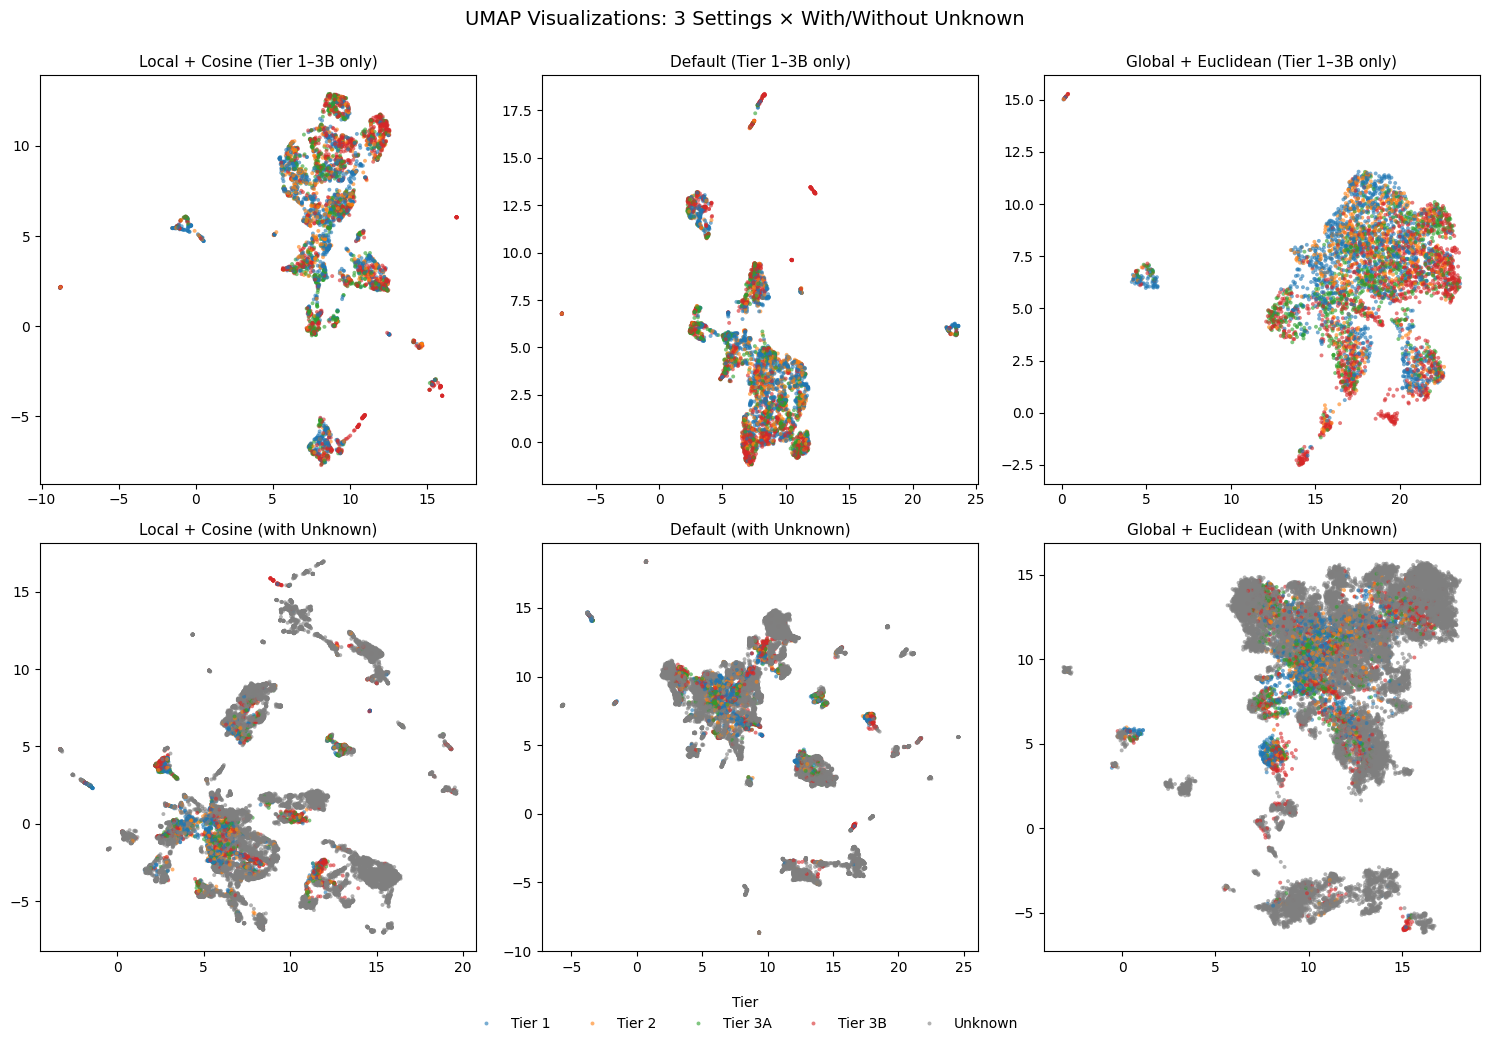

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from umap import UMAP

# ---------------------- Load and Prepare ----------------------
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
data = torch.load(GRAPH_PATH)
X = data.x.cpu().numpy()
X[np.isnan(X)] = 0

y_raw = np.array(data.y)
label_map = {'-1': "Unknown", 'Tier 1': "Tier 1", 'Tier 2': "Tier 2", 'Tier 3A': "Tier 3A", 'Tier 3B': "Tier 3B"}
y = np.vectorize(label_map.get)(y_raw)

# Preprocessing
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_qt = qt.fit_transform(X)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_qt)

# ---------------------- Settings ----------------------
umap_settings = [
    {"n_neighbors": 10, "min_dist": 0.1, "metric": "cosine", "label": "Local + Cosine"},
    {"n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean", "label": "Default"},
    {"n_neighbors": 50, "min_dist": 0.5, "metric": "euclidean", "label": "Global + Euclidean"},
]

palette = {
    "Tier 1": "#1f77b4",
    "Tier 2": "#ff7f0e",
    "Tier 3A": "#2ca02c",
    "Tier 3B": "#d62728",
    "Unknown": "#7f7f7f",
}

# ---------------------- Plotting ----------------------
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for row, include_unknown in enumerate([False, True]):
    # Select data
    mask = np.isin(y, ["Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]) if not include_unknown else np.ones_like(y, dtype=bool)
    X_sel = X_pca[mask]
    y_sel = y[mask]

    for col, setting in enumerate(umap_settings):
        ax = axs[row, col]
        umap_model = UMAP(n_neighbors=setting["n_neighbors"],
                          min_dist=setting["min_dist"],
                          metric=setting["metric"],
                          random_state=42)
        embedding = umap_model.fit_transform(X_sel)

        df_vis = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
        df_vis["Tier"] = y_sel

        order = ["Tier 1", "Tier 2", "Tier 3A", "Tier 3B"] + (["Unknown"] if include_unknown else [])
        sns.scatterplot(
            data=df_vis, x="UMAP1", y="UMAP2", hue="Tier", palette=palette,
            hue_order=order, s=8, alpha=0.6, ax=ax, linewidth=0
        )

        title_suffix = "with Unknown" if include_unknown else "Tier 1–3B only"
        ax.set_title(f"{setting['label']} ({title_suffix})", fontsize=11)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend().remove()

# Legend outside
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Tier", loc="lower center", ncol=6, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.suptitle("UMAP Visualizations: 3 Settings × With/Without Unknown", fontsize=14, y=1.03)
plt.show()

In [4]:
for c in df.columns:
    print(c)

Gene_Symbol
crispr_dependency_mean
crispr_dependency_std
crispr_dependency_min
crispr_dependency_max
crispr_dependency_median
crispr_dependency_strong_count
cnv_wgs_mean
cnv_wgs_std
cnv_wgs_min
cnv_wgs_max
cnv_wgs_median
expression_mean
expression_std
expression_min
expression_max
expression_median
expression_high_prop
damaging_mutation_sum
damaging_high_af_count
hotspot_mutation_sum
hotspot_high_af_count
GeneSize
ExAC_mean_rd
ExAC_gc_content
ExAC_complexity
ExAC_cds_len
ExAC_gene_length
ExAC_num_targ
ExAC_segdups
ExAC_dip
ExAC_del
ExAC_dup
ExAC_del.sing
ExAC_dup.sing
ExAC_del.sing.score
ExAC_dup.sing.score
ExAC_del.score
ExAC_dup.score
ExAC_cnv.score
ExAC_flag
MouseGenes_Essential
MouseGenes_Non-essential
MouseGenes_Overexpressed_in_the_brain
MouseGenes_GC%
GnomAD_obs_lof
GnomAD_exp_lof
GnomAD_oe_lof
GnomAD_oe_lof_lower
GnomAD_oe_lof_upper
GnomAD_obs_mis
GnomAD_exp_mis
GnomAD_oe_mis
GnomAD_oe_mis_lower
GnomAD_oe_mis_upper
GnomAD_lof_z
GnomAD_mis_z
GnomAD_pLI
GnomAD_pRec
GnomAD_pNull
G

In [6]:
set(df["GWAS_tissue_trait_flag"])

{0.0, 1.0}

In [7]:
df["GWAS_tissue_trait_flag"].sum()

6132.0

In [36]:
#!/usr/bin/env python
# filter_valid_genes.py

import pandas as pd
import mygene
import time
from tqdm import tqdm

# ---------- Step 1: Load gene list ----------
print("🔍 Loading gene symbols from feature table...")
NODE_TSV = "/home/zihend1/Genesis/KNOT/data/complete_feature_table.tsv"
node_df = pd.read_csv(NODE_TSV, sep="\t", dtype=str)
gene_symbols = node_df["Gene_Name"].dropna().unique().tolist()
print(f"✅ Total unique gene symbols loaded: {len(gene_symbols):,}")

# ---------- Step 2: Query MyGene.info ----------
print("🔎 Validating gene symbols with mygene.info ...")
mg = mygene.MyGeneInfo()
batch_size = 1000

valid_genes = set()
invalid_genes = set()

for i in tqdm(range(0, len(gene_symbols), batch_size), desc="Validating batches"):
    batch = gene_symbols[i:i + batch_size]
    try:
        out = mg.querymany(batch,
                           scopes="symbol",
                           fields="symbol",
                           species="human",
                           as_dataframe=True,
                           returnall=False)

        if isinstance(out, pd.DataFrame):
            # Ensure 'notfound' column is boolean
            out["notfound"] = out.get("notfound", False).fillna(False).astype(bool)

            # Found = not notfound
            found = out[~out["notfound"]].index.tolist()
            not_found = out[out["notfound"]].index.tolist()

            valid_genes.update(found)
            invalid_genes.update(not_found)

            print(f"🧬 Batch {i}: {len(found)} found, {len(not_found)} not found")

    except Exception as e:
        print(f"⚠️ Error on batch {i}: {str(e)}")
        time.sleep(2)

# ---------- Step 3: Save results ----------
valid_genes = sorted(list(valid_genes))
invalid_genes = sorted(list(invalid_genes))

print("\n✅ Validation complete.")
print(f"🟢 Valid gene symbols  : {len(valid_genes):,}")
print(f"🔴 Invalid gene symbols: {len(invalid_genes):,}")

# Save to files
pd.DataFrame(valid_genes, columns=["Gene_Symbol"]).to_csv("valid_gene_symbols.tsv", sep="\t", index=False)
pd.DataFrame(invalid_genes, columns=["Gene_Symbol"]).to_csv("invalid_gene_symbols.tsv", sep="\t", index=False)

print("\n📁 Files saved:")
print("  • valid_gene_symbols.tsv")
print("  • invalid_gene_symbols.tsv")


🔍 Loading gene symbols from feature table...
✅ Total unique gene symbols loaded: 19,846
🔎 Validating gene symbols with mygene.info ...


Validating batches:   0%|          | 0/20 [00:00<?, ?it/s]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
13 input query terms found dup hits:	[('NCF1C', 2), ('FAM86JP', 2), ('NBPF5P', 2), ('ERVK13-1', 2), ('OR4F4', 2), ('MEIS3P1', 2), ('PMS2P
32 input query terms found no hit:	['FBXL21', 'ZNF705F', 'RARRES3', 'IQCA1', 'FAM104B', 'ZBED9', 'BTNL10', 'C19orf70', 'CIR1', 'IMPAD1'
Validating batches:   5%|▌         | 1/20 [00:02<00:41,  2.20s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 0: 982 found, 32 not found


16 input query terms found dup hits:	[('WASH4P', 2), ('FAM86C2P', 2), ('PPP1R2P1', 9), ('POM121B', 2), ('NSUN5P2', 2), ('SNRPGP15', 2), (
45 input query terms found no hit:	['KIAA1324L', 'UHRF1BP1', 'HSPB11', 'HRASLS', 'HIST1H2BL', 'HIST1H2BN', 'HIST1H2AJ', 'HIST1H2BM', 'O
Validating batches:  10%|█         | 2/20 [00:04<00:37,  2.11s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 1000: 978 found, 45 not found


8 input query terms found dup hits:	[('BIRC8', 2), ('TMCO5B', 2), ('PRR34', 2), ('PRORSD1P', 2), ('PMS2P2', 2), ('DEFB108A', 3), ('CA5BP
50 input query terms found no hit:	['FAM160B2', 'TMEM246', 'FAM105A', 'ATP5S', 'C11orf70', 'DOPEY2', 'DUSP13', 'TMEM75', 'FAM71D', 'C22
Validating batches:  15%|█▌        | 3/20 [00:06<00:34,  2.02s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 2000: 959 found, 50 not found


13 input query terms found dup hits:	[('NAT8B', 3), ('IGKV3-11', 2), ('LINC01546', 2), ('IGHV5-10-1', 2), ('STRCP1', 2), ('FOLH1B', 2), (
36 input query terms found no hit:	['C3orf14', 'ADAL', 'C8orf37', 'LINC00643', 'TCRB', 'TCRA', 'C20orf78', 'KIAA0895L', 'C14orf37', 'PR
Validating batches:  20%|██        | 4/20 [00:08<00:33,  2.08s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 3000: 978 found, 36 not found


16 input query terms found dup hits:	[('GKN3P', 2), ('VN1R3', 2), ('IGKV1-12', 2), ('IGKV1-6', 2), ('RHPN2P1', 2), ('FAM157B', 2), ('DHRS
26 input query terms found no hit:	['KIAA1107', 'HIST1H2AB', 'C15orf53', '10-Mar', 'SPERT', 'TEX45', 'TMEM189-UBE2V1', 'C11orf94', 'C3o
Validating batches:  25%|██▌       | 5/20 [00:10<00:30,  2.02s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 4000: 993 found, 26 not found


26 input query terms found dup hits:	[('IGLV1-36', 2), ('MPTX1', 3), ('IGHV6-1', 2), ('FABP5P3', 2), ('MAGEA13P', 2), ('PIPSL', 2), ('IGH
39 input query terms found no hit:	['KIAA0754', 'C7orf49', 'ZCCHC11', 'PRSS47', 'C1orf43', 'B3GNTL1', 'C17orf98', '09-Mar', 'C9orf16', 
Validating batches:  30%|███       | 6/20 [00:12<00:28,  2.00s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 5000: 989 found, 39 not found


27 input query terms found dup hits:	[('IGLV5-52', 2), ('KLHL30-AS1', 2), ('KIF28P', 2), ('PRKY', 2), ('ZNF658B', 2), ('EP400P1', 3), ('N
56 input query terms found no hit:	['MINOS1', 'WDR63', 'KIAA0391', 'FAM71C', 'NAT6', 'C7orf65', 'FAM46D', 'KIAA0355', 'C18orf65', 'KIAA
Validating batches:  35%|███▌      | 7/20 [00:14<00:25,  1.96s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 6000: 974 found, 56 not found


9 input query terms found dup hits:	[('DNM1P46', 2), ('EGFEM1P', 2), ('TXLNGY', 2), ('ST20-AS1', 2), ('LINC00470', 2), ('USP17L23', 2), 
48 input query terms found no hit:	['C1orf134', 'AES', 'PQLC2L', 'HIST2H2BD', 'NARS', 'C9orf47', 'C1orf229', 'THEGL', 'CCDC129', 'TMEM1
Validating batches:  40%|████      | 8/20 [00:16<00:23,  1.96s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 7000: 961 found, 48 not found


35 input query terms found dup hits:	[('AHSA2P', 2), ('CCDC144NL', 2), ('IGHD', 2), ('IGHA2', 2), ('IGHA1', 2), ('IGHM', 2), ('IGHG4', 2)
42 input query terms found no hit:	['IQCG', 'PHB', 'TTC26', 'C5orf49', 'HIST2H4A', 'HIST1H2BC', 'STK19', 'CLLU1OS', 'KIAA1211L', 'FAM49
Validating batches:  45%|████▌     | 9/20 [00:18<00:22,  2.03s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 8000: 993 found, 42 not found


39 input query terms found dup hits:	[('IGKV2-28', 2), ('TCP10L2', 2), ('IGLV5-37', 2), ('IGHV1-2', 2), ('IGKV3-15', 2), ('OR10AC1', 3), 
42 input query terms found no hit:	['SLC26A10', 'HILS1', 'CDIPT-AS1', 'CCDC105', 'C20orf196', 'ELOA3B', 'OR56B2P', 'C16orf97', 'H1FOO',
Validating batches:  50%|█████     | 10/20 [00:20<00:20,  2.01s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 9000: 999 found, 42 not found


11 input query terms found dup hits:	[('DPH3P1', 2), ('ANKRD19P', 2), ('NCOR1P1', 2), ('OR10J3', 3), ('ATP6AP1L', 2), ('DPY19L2P1', 2), (
43 input query terms found no hit:	['C1orf140', 'H1FX', 'MUM1', 'C1orf137', 'METTL11B', 'MYLPF', 'H2BFS', 'C21orf59', 'FAM46B', 'HIST1H
Validating batches:  55%|█████▌    | 11/20 [00:22<00:17,  1.99s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 10000: 974 found, 43 not found


17 input query terms found dup hits:	[('IGKV1D-8', 2), ('TPRXL', 2), ('GUCY1B2', 2), ('ZNF542P', 2), ('LCN1P1', 2), ('MKRN9P', 2), ('RPL1
39 input query terms found no hit:	['ODF3L2', 'UHRF1BP1L', 'FAM69B', 'H2AFY', 'TROVE2', 'NOV', 'SSPO', 'TMEM133', 'FAM205BP', 'TCTEX1D4
Validating batches:  60%|██████    | 12/20 [00:24<00:15,  2.00s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 11000: 978 found, 39 not found


16 input query terms found dup hits:	[('IGKV2-40', 2), ('STAG3L4', 2), ('PRAMEF22', 2), ('OR5G3', 2), ('OR4Q2', 2), ('CHCHD2P9', 2), ('VE
42 input query terms found no hit:	['WASHC2D', 'WDR34', 'FAM71B', 'C9orf170', 'FAM57A', 'FAM212A', 'KIF1BP', 'FAM213B', 'PRR31', 'TMEM2
Validating batches:  65%|██████▌   | 13/20 [00:26<00:13,  1.97s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 12000: 980 found, 42 not found


12 input query terms found dup hits:	[('FXYD6P3', 2), ('ORAI1', 2), ('OR3A4P', 2), ('FKBP9P1', 2), ('PRORY', 2), ('IGKV2-29', 2), ('PMCHL
39 input query terms found no hit:	['C9orf84', 'GGTA1P', 'C6orf106', 'SDCCAG3', 'C11orf49', '07-Sep', 'C7orf69', 'C10orf91', 'C9orf131'
Validating batches:  70%|███████   | 14/20 [00:27<00:11,  1.95s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 13000: 973 found, 39 not found


16 input query terms found dup hits:	[('TPTE2P1', 2), ('HSP90AA4P', 3), ('HSP90AA5P', 2), ('HSP90AB4P', 2), ('ARHGAP5-AS1', 2), ('CCNYL3'
34 input query terms found no hit:	['C17orf53', 'C10orf25', 'C9orf64', 'IBA57-AS1', 'ELOA3D', 'FAM69A', 'SLC9A3R2', 'FAM90A24P', 'ZNF80
Validating batches:  75%|███████▌  | 15/20 [00:30<00:10,  2.01s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 14000: 984 found, 34 not found


25 input query terms found dup hits:	[('GUSBP1', 2), ('FAM157A', 3), ('EXOC3-AS1', 2), ('AGAP11', 2), ('FAM220BP', 2), ('NBEAP1', 2), ('R
39 input query terms found no hit:	['06-Sep', 'SKIV2L', 'KIAA0141', 'FAM196B', 'HIST1H2AD', 'COLCA2', 'CCDC58', 'C21orf33', 'LCA10', 'M
Validating batches:  80%|████████  | 16/20 [00:32<00:08,  2.13s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 15000: 988 found, 39 not found


25 input query terms found dup hits:	[('SLCO1B7', 2), ('IGHJ1', 2), ('LPAL2', 2), ('IGKV1-9', 2), ('IGKV2-24', 2), ('IGKV1-8', 2), ('IGKV
48 input query terms found no hit:	['C16orf58', 'H2AFB1', 'SSSCA1', 'FAM189A1', '06-Mar', 'LINC00032', 'C6orf203', 'KIAA0556', 'FAM58BP
Validating batches:  85%|████████▌ | 17/20 [00:34<00:06,  2.06s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 16000: 980 found, 48 not found


17 input query terms found dup hits:	[('FAM47DP', 2), ('RRP7BP', 2), ('ADGRE4P', 2), ('CROCCP2', 2), ('ARIH2OS', 2), ('NCF1B', 2), ('NANO
34 input query terms found no hit:	['C7orf31', 'HIST1H4G', 'BMT2', 'HIST1H2BK', 'C9orf118', 'C20orf187', 'FAM173A', 'FOPNL', 'PALM2-AKA
Validating batches:  90%|█████████ | 18/20 [00:36<00:04,  2.03s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 17000: 984 found, 34 not found


20 input query terms found dup hits:	[('IGLV7-43', 2), ('HSP90AA2P', 2), ('ZNF355P', 2), ('SNURFL', 2), ('ABCC13', 2), ('PRSS29P', 2), ('
53 input query terms found no hit:	['C14orf178', 'PQLC3', 'C11orf80', 'C1orf147', 'TCTEX1D1', 'C16orf45', 'FAM207A', 'C5orf38', 'HIST3H
Validating batches:  95%|█████████▌| 19/20 [00:38<00:02,  2.06s/it]Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🧬 Batch 18000: 967 found, 53 not found


9 input query terms found dup hits:	[('BTN2A3P', 2), ('FMO6P', 2), ('SERHL', 2), ('C5orf67', 2), ('FAM90A2P', 2), ('RPL37AP8', 2), ('FAM
27 input query terms found no hit:	['C11orf88', 'BHLHB9', 'KIAA1324', 'LINC00337', 'GK3P', 'FAM183A', 'ALG1L', 'BCE1', 'TTC37', 'KDELC1
Validating batches: 100%|██████████| 20/20 [00:40<00:00,  2.04s/it]

🧬 Batch 19000: 828 found, 27 not found

✅ Validation complete.
🟢 Valid gene symbols  : 19,032
🔴 Invalid gene symbols: 814

📁 Files saved:
  • valid_gene_symbols.tsv
  • invalid_gene_symbols.tsv


In [31]:
import os
import pandas as pd

# ===== 文件路径 =====
valid_gene_file = "/home/zihend1/Genesis/KNOT/data/symbol/valid_gene_symbols.tsv"
feature_paths = {
    "crispr": "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Feature/Depmap/processed/feature/crispr_dependency_features.tsv",
    "cnv": "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Feature/Depmap/processed/feature/cnv_wgs_features.tsv",
    "expr": "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Feature/Depmap/processed/feature/expression_features.tsv",
    "damaging": "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Feature/Depmap/processed/feature/damaging_mutation_features.tsv",
    "hotspot": "/extra/zhanglab0/INDV/zihend1/Genesis/KNOT/Feature/Depmap/processed/feature/hotspot_mutation_features.tsv",
    "drugnomeai": "/home/zihend1/Genesis/KNOT/data/raw/Triage_complete_feature_table.tsv"
}
drug_label_path = "/home/zihend1/Genesis/KNOT/data/raw/gene_druggable_labels.csv"
pharos_label_path = "/home/zihend1/Genesis/KNOT/data/raw/pharos_GF_wINDEX.csv"
output_path = "/home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv"

# ===== 加载有效基因列表 =====
valid_genes = pd.read_csv(valid_gene_file, header=None, names=["Gene_Symbol"])

# ===== 初始化合并表格 =====
features = valid_genes.copy()

# ===== 加载特征表并合并 =====
for name, path in feature_paths.items():
    df = pd.read_csv(path, sep="\t" if path.endswith(".tsv") else ",")

    # 统一列名
    if 'Gene_Name' in df.columns:
        df = df.rename(columns={"Gene_Name": "Gene_Symbol"})

    # 删除错误表头行和重复基因
    df = df[df['Gene_Symbol'].astype(str).str.lower() != 'gene_symbol']
    df = df.drop_duplicates(subset="Gene_Symbol")

    # 合并
    features = features.merge(df, on="Gene_Symbol", how="left")

# ===== 合并标签 =====
drug_label = pd.read_csv(drug_label_path)[["Gene_Name", "druggability_tier"]].rename(columns={"Gene_Name": "Gene_Symbol"})
pharos_label = pd.read_csv(pharos_label_path)[["Gene_Name", "idgTDL"]].rename(columns={"Gene_Name": "Gene_Symbol"})
labels = drug_label.merge(pharos_label, on="Gene_Symbol", how="outer")
labels = labels[labels["Gene_Symbol"].astype(str).str.lower() != "gene_symbol"]

# 合并标签到特征表
features = features.merge(labels, on="Gene_Symbol", how="left")

# ===== 删除可能的冗余表头行（再次保险） =====
features = features[features["Gene_Symbol"].astype(str).str.lower() != "gene_symbol"]
features["druggability_tier"] = features["druggability_tier"].fillna("-1")

# ===== 填补缺失值（推荐方式）=====
features.fillna(0, inplace=True)
print("✅ 已将所有 NaN 用 0 替代")

# ===== 保存 =====
os.makedirs(os.path.dirname(output_path), exist_ok=True)
features.to_csv(output_path, sep="\t", index=False)
print(f"✅ 成功保存到: {output_path}")

✅ 已将所有 NaN 用 0 替代
✅ 成功保存到: /home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv
✅ 成功保存到: /home/zihend1/Genesis/KNOT/data/processed/final_gene_druggability_features.tsv


In [32]:
features

,Gene_Symbol,crispr_dependency_mean,crispr_dependency_std,crispr_dependency_min,crispr_dependency_max,crispr_dependency_median,crispr_dependency_strong_count,cnv_wgs_mean,cnv_wgs_std,cnv_wgs_min,...,IPR_sf_WD40/YVTN repeat-like-containing domain superfamily,IPR_sf_Winged helix DNA-binding domain superfamily,IPR_sf_Winged helix-like DNA-binding domain superfamily,IPR_sf_Zinc finger C2H2 superfamily,"IPR_sf_Zinc finger, FYVE/PHD-type","IPR_sf_Zinc finger, RING/FYVE/PHD-type",IPR_sf_von Willebrand factor A-like domain superfamily,known_gene,druggability_tier,idgTDL
1,A1BG,-0.061496,0.106872,-0.626283,0.464101,-0.058588,1.0,1.089149,0.324947,0.353139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3B,Tbio
2,A1CF,-0.068786,0.103610,-0.826178,0.412459,-0.066809,4.0,1.006446,0.243072,0.448895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tbio
3,A2M,0.033482,0.097134,-0.331599,0.428117,0.032418,0.0,1.107545,0.297580,0.375062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3B,Tbio
4,A2ML1,0.068928,0.098860,-0.376827,0.480926,0.067592,0.0,1.022944,0.275505,0.316907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Tier 3A,Tbio
5,A3GALT2,-0.099010,0.125272,-0.672216,0.383656,-0.090788,4.0,0.966693,0.197476,0.296045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19240,ZYG11A,-0.047944,0.102375,-0.431871,0.571468,-0.050927,0.0,1.003897,0.191902,0.333292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
19241,ZYG11B,-0.140896,0.127530,-0.806002,0.410633,-0.139932,8.0,1.006239,0.200860,0.475033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark
19242,ZYX,-0.043318,0.128729,-0.532427,0.370096,-0.034781,2.0,1.094383,0.298147,0.350219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tbio
19243,ZZEF1,-0.140179,0.119869,-0.622824,0.305158,-0.139425,10.0,0.965827,0.237389,0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Tdark


In [33]:
set(features["druggability_tier"])

{'-1', 'Tier 1', 'Tier 2', 'Tier 3A', 'Tier 3B'}

In [34]:
set(features["idgTDL"])

{'Tbio', 'Tchem', 'Tclin', 'Tdark'}

In [35]:
# 显示所有含 NaN 的列及其数量和比例
nan_summary = features.isna().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)

if not nan_summary.empty:
    total_rows = features.shape[0]
    nan_report = pd.DataFrame({
        "NaN_Count": nan_summary,
        "NaN_Percent": nan_summary / total_rows * 100
    })
    print("🔍 Columns with NaNs:\n")
    print(nan_report)
else:
    print("✅ No NaNs found in features.")


✅ No NaNs found in features.


In [36]:
# 找出每一行是否存在 NaN（即该基因是否有缺失值）
gene_nan_mask = features.isna().any(axis=1)

# 提取对应的 Gene_Symbol 及其 NaN 列数量
genes_with_nan = features.loc[gene_nan_mask, "Gene_Symbol"]
num_genes_with_nan = genes_with_nan.shape[0]

print(f"⚠️ 有缺失值的基因数量: {num_genes_with_nan}")
print("🔍 示例有缺失的基因前 10 个:")
print(genes_with_nan.head(10).tolist())

# 若要查看这些基因在哪些列缺失，可以进一步输出：
print("\n📋 每个缺失基因的 NaN 列:")
nan_details = features.loc[gene_nan_mask]
nan_columns_per_gene = nan_details.isna().sum(axis=1)
print(nan_columns_per_gene.head(10))


⚠️ 有缺失值的基因数量: 0
🔍 示例有缺失的基因前 10 个:
[]

📋 每个缺失基因的 NaN 列:
Series([], dtype: float64)


In [30]:
valid_gene_df = pd.read_csv(valid_gene_file, header=None, names=["Gene_Symbol"])
valid_genes = set(valid_gene_df["Gene_Symbol"])

features = valid_gene_df.copy()

for name, path in feature_paths.items():
    df = pd.read_csv(path, sep="\t" if path.endswith(".tsv") else ",")
    if 'Gene_Name' in df.columns:
        df = df.rename(columns={"Gene_Name": "Gene_Symbol"})
    df = df[df['Gene_Symbol'].astype(str).str.lower() != 'gene_symbol']
    df = df.drop_duplicates(subset="Gene_Symbol")
    
    # ✅ 打印交集覆盖率
    overlap = df["Gene_Symbol"].isin(valid_genes).sum()
    print(f"{name:<10} covers {overlap:>5}/{len(valid_genes):<5} valid genes "
          f"({overlap/len(valid_genes)*100:.2f}%)")
    
    features = features.merge(df, on="Gene_Symbol", how="left")


crispr     covers 17325/19033 valid genes (91.03%)
cnv        covers 17730/19033 valid genes (93.15%)
expr       covers 18213/19033 valid genes (95.69%)
damaging   covers 17181/19033 valid genes (90.27%)
hotspot    covers   518/19033 valid genes (2.72%)
drugnomeai covers 19032/19033 valid genes (99.99%)
